In [26]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
dataset_path = 'lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/'

Note: you may need to restart the kernel to use updated packages.


In [27]:
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model

os.listdir('/home/dv/')

!mkdir /home/dv/.kaggle

!cp kaggle.json /home/dv/.kaggle

!chmod 600 /home/dv/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/lfw-dataset

!mkdir lfw-dataset

!unzip lfw-dataset.zip -d lfw-dataset

In [28]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("lfw-dataset/pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("lfw-dataset/peopleDevTrain.csv")

In [29]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

/tmp/ipykernel_13107/3328116756.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  image_paths = image_paths.drop("images",1)


In [30]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


<Axes: >

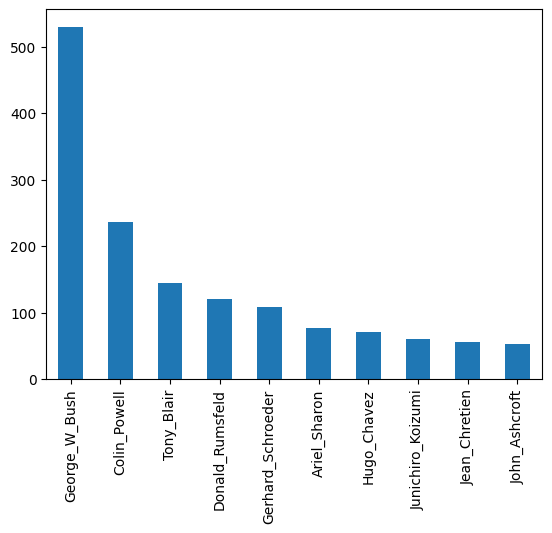

In [31]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [32]:
# Добавляем колонку с z, которая для данного случая равна 0 для всех строк (картинки различны)
mismatchpairsDevTrain['z'] = 0

base = 'lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

mismatchpairsDevTrain.imagenum1 = mismatchpairsDevTrain.imagenum1.astype(str)
mismatchpairsDevTrain.imagenum2 = mismatchpairsDevTrain.imagenum2.astype(str)

mismatchpairsDevTrain['path_1'] = base + "/" + mismatchpairsDevTrain.name + \
"/" + mismatchpairsDevTrain.name + "_" + ('000' + mismatchpairsDevTrain.imagenum1).apply(lambda x: x[-4:]) + ".jpg"

mismatchpairsDevTrain['path_2'] = base + "/" + mismatchpairsDevTrain['name.1'] + \
"/" + mismatchpairsDevTrain['name.1'] + "_" + ('000' + mismatchpairsDevTrain.imagenum2).apply(lambda x: x[-4:]) + ".jpg"

mismatchpairsDevTrain.drop(columns = ['name', 'imagenum1', 'name.1', 'imagenum2'], inplace = True)

# Цикл отработал без ошибок, значит все адреса правильные
for i in range(mismatchpairsDevTrain.shape[0]):
    im = Image.open(mismatchpairsDevTrain.path_1[i])
    im = Image.open(mismatchpairsDevTrain.path_2[i])

In [33]:
# Добавляем колонку с z, которая для данного случая равна 1 для всех строк (картинки похожи)
matchpairsDevTrain['z'] = 1

base = 'lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

matchpairsDevTrain.imagenum1 = matchpairsDevTrain.imagenum1.astype(str)
matchpairsDevTrain.imagenum2 = matchpairsDevTrain.imagenum2.astype(str)

matchpairsDevTrain['path_1'] = base + "/" + matchpairsDevTrain.name + \
"/" + matchpairsDevTrain.name + "_" + ('000' + matchpairsDevTrain.imagenum1).apply(lambda x: x[-4:]) + ".jpg"

matchpairsDevTrain['path_2'] = base + "/" + matchpairsDevTrain.name + \
"/" + matchpairsDevTrain.name + "_" + ('000' + matchpairsDevTrain.imagenum2).apply(lambda x: x[-4:]) + ".jpg"

matchpairsDevTrain.drop(columns = ['name', 'imagenum1', 'imagenum2'], inplace = True)

# Цикл отработал без ошибок, значит все адреса правильные
for i in range(matchpairsDevTrain.shape[0]):
    im = Image.open(matchpairsDevTrain.path_1[i])
    im = Image.open(matchpairsDevTrain.path_2[i])

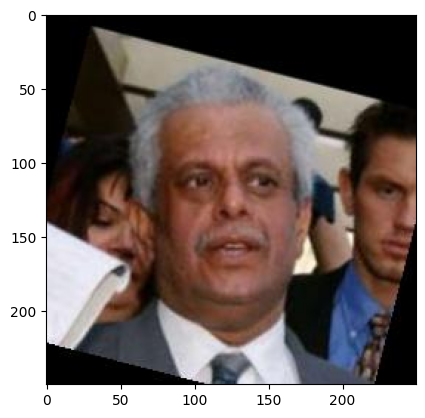

In [34]:
#Выведем некоторые изображения

im = Image.open(matchpairsDevTrain.path_1[7])
plt.imshow(im)

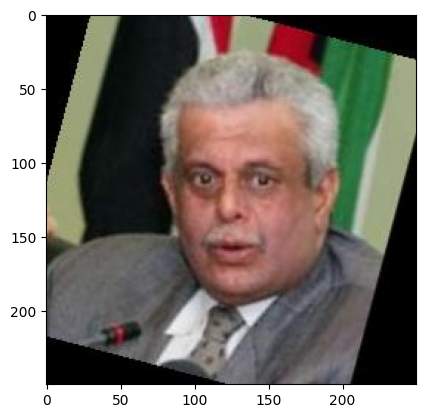

In [35]:
im = Image.open(matchpairsDevTrain.path_2[7])
plt.imshow(im)

In [36]:
AllDevTrain = pd.concat([matchpairsDevTrain, mismatchpairsDevTrain])

from sklearn.utils import shuffle
AllDevTrain = shuffle(AllDevTrain)

AllDevTrain = AllDevTrain.reset_index().drop(columns = ['index'])

AllDevTrain.z.value_counts()

0    1100
1    1100
Name: z, dtype: int64

In [37]:
AllDevTrain

,z,path_1,path_2
0,0,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...
1,1,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...
2,0,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...
3,1,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...
4,0,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...
...,...,...,...
2195,0,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...
2196,1,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...
2197,0,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...
2198,0,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...,lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/...


In [38]:
train_x = np.array([img_to_array(
                    load_img(img, target_size=(250, 250))
                    ) for img in AllDevTrain['path_1'].values.tolist()])

train_y = np.array([img_to_array(
                    load_img(img, target_size=(250, 250))
                    ) for img in AllDevTrain['path_2'].values.tolist()])

train_x = train_x.astype('float32')/255.0
train_y = train_y.astype('float32')/255.0

train_z = np.array(AllDevTrain['z'].values)
train_z = train_z.astype('float32')

In [39]:
# Добавляем колонку с z, которая для данного случая равна 0 для всех строк (картинки различны)
mismatchpairsDevTest['z'] = 0

base = 'lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

mismatchpairsDevTest.imagenum1 = mismatchpairsDevTest.imagenum1.astype(str)
mismatchpairsDevTest.imagenum2 = mismatchpairsDevTest.imagenum2.astype(str)

mismatchpairsDevTest['path_1'] = base + "/" + mismatchpairsDevTest.name + \
"/" + mismatchpairsDevTest.name + "_" + ('000' + mismatchpairsDevTest.imagenum1).apply(lambda x: x[-4:]) + ".jpg"

mismatchpairsDevTest['path_2'] = base + "/" + mismatchpairsDevTest['name.1'] + \
"/" + mismatchpairsDevTest['name.1'] + "_" + ('000' + mismatchpairsDevTest.imagenum2).apply(lambda x: x[-4:]) + ".jpg"

mismatchpairsDevTest.drop(columns = ['name', 'imagenum1', 'name.1', 'imagenum2'], inplace = True)

# Цикл отработал без ошибок, значит все адреса правильные
for i in range(mismatchpairsDevTest.shape[0]):
    im = Image.open(mismatchpairsDevTest.path_1[i])
    im = Image.open(mismatchpairsDevTest.path_2[i])

In [40]:
# Добавляем колонку с z, которая для данного случая равна 1 для всех строк (картинки похожи)
matchpairsDevTest['z'] = 1

base = 'lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

matchpairsDevTest.imagenum1 = matchpairsDevTest.imagenum1.astype(str)
matchpairsDevTest.imagenum2 = matchpairsDevTest.imagenum2.astype(str)

matchpairsDevTest['path_1'] = base + "/" + matchpairsDevTest.name + \
"/" + matchpairsDevTest.name + "_" + ('000' + matchpairsDevTest.imagenum1).apply(lambda x: x[-4:]) + ".jpg"

matchpairsDevTest['path_2'] = base + "/" + matchpairsDevTest.name + \
"/" + matchpairsDevTest.name + "_" + ('000' + matchpairsDevTest.imagenum2).apply(lambda x: x[-4:]) + ".jpg"

matchpairsDevTest.drop(columns = ['name', 'imagenum1', 'imagenum2'], inplace = True)

# Цикл отработал без ошибок, значит все адреса правильные
for i in range(matchpairsDevTest.shape[0]):
    im = Image.open(matchpairsDevTest.path_1[i])
    im = Image.open(matchpairsDevTest.path_2[i])

In [41]:
AllDevTest = pd.concat([matchpairsDevTest, mismatchpairsDevTest])
from sklearn.utils import shuffle
AllDevTest = shuffle(AllDevTest)
AllDevTest = AllDevTest.reset_index().drop(columns = ['index'])
AllDevTest.z.value_counts()

1    500
0    500
Name: z, dtype: int64

In [42]:
test_x = np.array([img_to_array(
                    load_img(img, target_size=(250, 250))
                    ) for img in AllDevTest['path_1'].values.tolist()])

test_y = np.array([img_to_array(
                    load_img(img, target_size=(250, 250))
                    ) for img in AllDevTest['path_2'].values.tolist()])

test_x = test_x.astype('float32')/255.0
test_y = test_y.astype('float32')/255.0

test_z = np.array(AllDevTest['z'].values)
test_z = test_z.astype('float32')

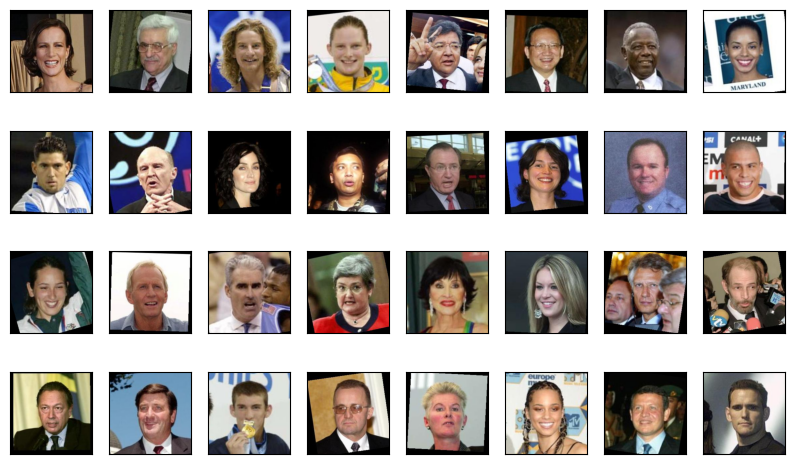

In [43]:
some_samples = test_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,:])
    plt.xticks([]), plt.yticks([])
plt.show()

In [44]:
EMB_SIZE = 64

WEIGHT_DECAY = 0.001

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

2023-02-28 23:29:20.182150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 23:29:20.182261: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dv/miniconda3/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-28 23:29:20.182307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dv/miniconda3/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-28 23:29:20.182345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could n

In [45]:
MARGIN = 10.0

def contastive_loss(embs1, embs2, z):
    
    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [46]:
BATCH_SIZE = 32
NUM_EPOCHS = 5

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y, train_z))
#train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
#train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y, test_z))
test_ds = test_ds.batch(BATCH_SIZE)

2023-02-28 23:29:45.853954: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1650000000 exceeds 10% of free system memory.
2023-02-28 23:29:46.666925: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1650000000 exceeds 10% of free system memory.


In [47]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [48]:
%%time
for epoch in range(NUM_EPOCHS):
    for iteration, (image1, image2, z) in enumerate(train_ds):
      
        # Forward
        with tf.GradientTape() as tape:
            embs1 = model(image1)
            embs2 = model(image2)
            loss_value = contastive_loss(embs1, embs2, z)
          
        # Backward
        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))

        if iteration % 20 == 0:
            print('Epoch: {} [{}] Loss: {}'.format(epoch, iteration, loss_value.numpy()))

    # Проводим валидацию после каждой эпохи
    test_loss = 0
    for iteration, (image1, image2, z) in enumerate(test_ds):
        test_embs1 = model(image1)
        test_embs2 = model(image2)
        test_loss += contastive_loss(test_embs1, test_embs2, z).numpy()
    test_loss /= iteration
    print('Test loss:', test_loss)

2023-02-28 23:30:59.352184: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1650000000 exceeds 10% of free system memory.
2023-02-28 23:31:00.193249: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1650000000 exceeds 10% of free system memory.


Epoch: 0 [0] Loss: 55.073158264160156
Epoch: 0 [20] Loss: 36.09568786621094
Epoch: 0 [40] Loss: 27.92401885986328
Epoch: 0 [60] Loss: 22.930301666259766
Test loss: 30.044711082212388
Epoch: 1 [0] Loss: 24.541109085083008
Epoch: 1 [20] Loss: 28.983903884887695
Epoch: 1 [40] Loss: 24.09686851501465
Epoch: 1 [60] Loss: 20.744293212890625
Test loss: 30.81064175021264
Epoch: 2 [0] Loss: 25.84058380126953
Epoch: 2 [20] Loss: 26.653621673583984
Epoch: 2 [40] Loss: 21.412702560424805
Epoch: 2 [60] Loss: 18.02845001220703
Test loss: 22.861360057707756
Epoch: 3 [0] Loss: 17.700340270996094
Epoch: 3 [20] Loss: 26.17168617248535
Epoch: 3 [40] Loss: 22.46261215209961
Epoch: 3 [60] Loss: 17.902786254882812
Test loss: 21.328026187035345
Epoch: 4 [0] Loss: 15.632747650146484
Epoch: 4 [20] Loss: 25.688514709472656
Epoch: 4 [40] Loss: 21.715497970581055
Epoch: 4 [60] Loss: 20.743606567382812
Test loss: 24.269107880130893
CPU times: user 2h 15min 4s, sys: 29min 26s, total: 2h 44min 31s
Wall time: 18min 9

In [49]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


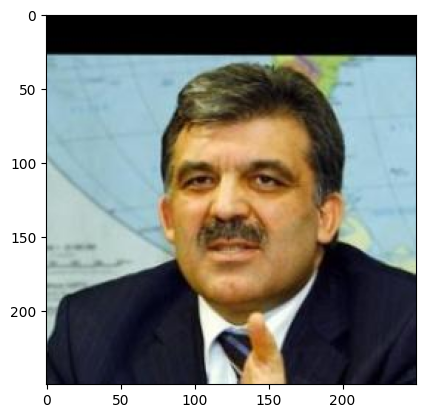

In [50]:
im1 = Image.open(matchpairsDevTest.path_1[0])
plt.imshow(im1)

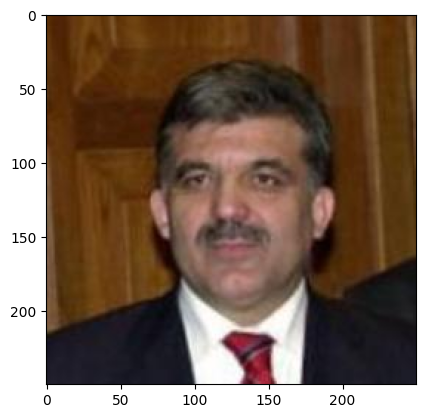

In [51]:
im2 = Image.open(matchpairsDevTest.path_2[0])
plt.imshow(im2)

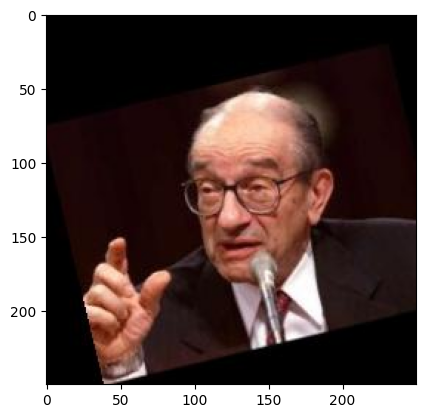

In [52]:
im3 = Image.open(matchpairsDevTest.path_2[5])
plt.imshow(im3)

In [53]:
new_embs = model(np.stack((im1, im2, im3), axis=0))

In [54]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  984.7796707893599
A2 <-> B1:  1629.8653318602737
A1 <-> B1:  1611.8868601735048
